In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from eda.util import set_ax_pixel_size

from mafia.voting_strategies import *

plt.style.use('ggplot')

typical_tactics = [
    ChancesOfVotingForRed(0.50),
    ChancesOfVotingForBlack(0.50),
    AlwaysVoteForBlackCheckedBySheriff(),
    ChancesOfVotingForRedThatIsCheckedBySheriff(0),
    MafiaKillsUncoveredRed(1),
    MafiaKillsUncoveredSheriff(1),
    RedMustPutOnVoteUncoveredBlack(1),
    RedMustAvoidToPutOnVoteUncoveredRed(0),
]
skilled_tactics = [
    ChancesOfVotingForRed(0.10),
    ChancesOfVotingForBlack(0.90),
    AlwaysVoteForBlackCheckedBySheriff(),
    ChancesOfVotingForRedThatIsCheckedBySheriff(0),
    MafiaKillsUncoveredRed(1),
    MafiaKillsUncoveredSheriff(1),
    RedMustPutOnVoteUncoveredBlack(1),
    RedMustAvoidToPutOnVoteUncoveredRed(0),
]
players_strategies = [typical_tactics for _ in range(10)]
players_strategies[0] = skilled_tactics
players_strategies[1] = skilled_tactics


game = Game()
game.init_game(players_strategies)
while True:
    game.commit_night_events()
    if game.the_game_is_over:
        break
    game.commit_day_events()
    if game.the_game_is_over:
        break


In [2]:
df = DataFrame(columns=['g_time', 'g_who_wins', 'g_total_rounds', 'g_when_sheriff_killed', 'p_#', 'p_role', 'votes_for_reds', 'votes_for_black'])
for g in range(1000):
    game = Game()
    game.init_game(players_strategies)
    while True:
        game.commit_night_events()
        if game.the_game_is_over:
            break
        game.commit_day_events()
        if game.the_game_is_over:
            break

    stats = []
    p: Player

    for p in game.players:
        num_of_votes_for_reds = len([x for x in game.game_statistics['who_vote_who'] if p == x[0] and x[1].is_red()])
        num_of_votes_for_black = len([x for x in game.game_statistics['who_vote_who'] if p == x[0] and x[1].is_maf()])
        stats.append([game.game_time, game.who_wins, game.day_number, game.game_statistics['when_sheriff_killed'], p.number, p.role, num_of_votes_for_reds, num_of_votes_for_black])

    df = pd.concat([df, DataFrame(columns=['g_time', 'g_who_wins', 'g_total_rounds', 'g_when_sheriff_killed', 'p_#', 'p_role', 'votes_for_reds', 'votes_for_black'], data=stats)], ignore_index=True)

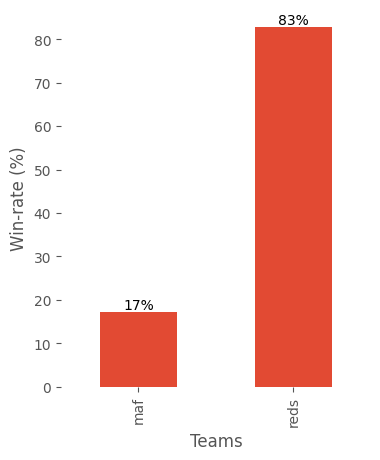

In [3]:
who_wins = df.groupby(['g_time', 'g_who_wins']).agg(wins_count=('g_who_wins', 'count')).reset_index()
who_wins = who_wins.groupby('g_who_wins').agg(wins_by_team=('g_who_wins', 'count')) / len(who_wins) * 100
ax = who_wins.plot(kind='bar', legend=False)
ax.set_frame_on(False)
ax.set_xlabel('Teams')
ax.set_ylabel('Win-rate (%)')
ax.bar_label(ax.containers[0], fmt='%.0f%%')
set_ax_pixel_size(ax, width=400)


In [4]:
win_rate_by_sheriff_longevity = df.groupby(['g_time', 'g_when_sheriff_killed', 'g_who_wins']).agg(wins_count=('g_who_wins', 'count')).reset_index()


win_rate_by_sheriff_longevity_g = win_rate_by_sheriff_longevity.groupby(['g_who_wins', 'g_when_sheriff_killed']).agg(wins_by_team=('g_who_wins', 'count')) / len(win_rate_by_sheriff_longevity) * 100
win_rate_by_sheriff_longevity_g


wins_by_team
g_who_wins g_when_sheriff_killed              
maf        0                               3.3
           1                               4.1
           2                               8.5
           10                              1.3
reds       0                              10.5
           1                              11.0
           2                              58.3
           10                              3.0

Решил развлечь себя написанием симулятора игры в мафию. Это полностью синтетическая модель игр, имитирующая ход игры от начала до конца, в соответствии с правилами классической игры. Но прелесть этого симулятора в том, что поддерживает настройку вероятностей действий игроков. Есть возможности настройки, как будут действовать игроки в тех или иных ситуациях. Одна из главных настроек: это способность (%) находить мафию.

Я запустил симуляции тысяч игр на разных настройках поведения игроков за столом и хочу поделиться с вами интересными результатами.

Первая симуляция 1000 игр. Входные настройки:
* Каждый игрок голосует сам, как считает нужным, все голосования свободные
* Игроки голосуют вместе с шерифом в чёрных после того, как шериф вскрывается и объявляет чёрные проверки
* Красные проверки не голосуются
* Мафия голосует так же, как и красные игроки и тоже не договариваясь, куда голосовать
* Мафия голосует с шерифом
* В этой симуляции игроки одинаково голосуют как за красных, так и за чёрных (способность находить цвета выключена). Другими словами, шанс, что красный игрок правильно определит того или иного игрока за столом красным - 50%

![](images/img.png)
Здесь видно, что когда игроки действуют случайным образом и независимо друг от друга, мафия побеждает в 4 раза чаще мирных.

В этой ситуации шериф значительно спасает положение красных. Но велико влияние шерифа за столом? Далее я совсем убрал фактор шерифа. Вот 1000 игр, где игроки действуют всё так же случайным образом, но теперь ещё и без шерифских проверок.

![](images/img_1.png)

Без шерифа, без согласованных голосований и без способностей находить чёрных у красных есть всего около 10% шансов на победу. При это мафия так же часто голосует в свою мафию, как и красные это делают.

Далее я добавил красным и чёрным больше шансов голосовать в чёрных и меньше шансов голосовать в красных. Пусть показатель способностей находить красных будет чуть выше среднего, скажем 65% вместо 50% как было выше. Другими словами, добавим красным немного способностей находить цвета.
![](images/img_2.png)
Здесь игроки всё ещё играют рассогласовано и чёрные не думают, когда в кого голосовать. Но чёрные убивают шерифа сразу, как только шериф вскрывается. И все игроки голосуют в чёрную проверку и никогда не голосуют в красные проверки. Как видим, аж 65% скилла к нашей красной игре необходимо, чтобы не проигрывать хотя бы половину игр!

Следующий эксперимент особенно интересен. В нём я добавляю в стол одного очень талантливого игрока, способного находить цвета в 90% случаев верно. Остальные игроки действуют без способностей находить цвета.
![](images/img_3.png)
За "плохим столом" такой игрок будет проигрывать две трети своих игр. Но на длинной дистанции результативность красных команд поднимется. Не забываем, что треть игр этот опытный игрок играет за чёрных.

А теперь пусть за столом будет 2 опытных игрока, не ошибающихся в цветах в 90% случаев:
![](images/img_4.png)
При этом они всё ещё голосуют рассогласованно, не вместе.

5 опытных игроков:
![](images/img_5.png)

А вот вероятность побед, если все 10 игроков умеют определить цвет другого игрока с 90% точностью:
![](images/img_6.png)
